# Kelmarsh SCADA merge_missingvalues

### The purpose of this notebook: 
### 1. To compile all of the turbine data together into a singel power signal output for the entire wind farm.
### 2. To impute estimates for missing values using k-NN method.

Kelmarsh SCADA data - West Northamptonshire, England:
6 turbines - Senvion MM92

In [1]:
# 26Mar2024
# @Deignan

import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from datetime import datetime
import zipfile

specific_column = 'Power (kW)'
date_column = '# Date and time'

# Data Merging

In [2]:

# read_and_filter_excel
def read_and_filter_excel(file_path, specific_column, date_column):
    # Read the Excel file
    df = pd.read_csv(file_path, sep=',', skiprows = 9,  usecols=[specific_column, date_column] )

    df[date_column] = pd.to_datetime(df[date_column])
    sorted_df = df.sort_values(by=date_column)

    return sorted_df

# read_zip
def read_zip(file_path_zip):
    
    combined_data = pd.DataFrame()
    zf_open = zipfile.ZipFile(file_path_zip, mode = 'r')
    count = 0
    
    for filename in zf_open.namelist():
        if filename.startswith('Turbine'):
            
            print("filename = ", filename)
            with zf_open.open(filename) as f:
                
                 df_final = read_and_filter_excel(f, specific_column, date_column)
            
            count +=1
            df_final[date_column] = pd.to_datetime(df_final[date_column])
            sorted_df = df_final.sort_values(by=date_column)
            
            combined_data = pd.concat([combined_data, sorted_df], ignore_index=True)   
            #print("combined_data = ",combined_data)   
    
    return combined_data, count



In [3]:

pattern_zip = f".\\Kelmarsh SCADA\\Kelmarsh*.zip"
files_zip = glob.glob(pattern_zip)

combined_data_final = pd.DataFrame()

count = 0
for file_zip in files_zip:
    print(f"Processing file: {file_zip}")
    zf, zipcount = read_zip(file_zip)
    #print(zf)
    
    combined_data_final = pd.concat([combined_data_final, zf], ignore_index=True) 
    combined_data_final = combined_data_final.sort_values(by=date_column) 
    #print("combined_data_final = ",combined_data_final)
    count += zipcount

combined_data_final_sorted = combined_data_final.sort_values(by=date_column)
print(f"Processing complete. {count} files processed")    



Processing file: .\Kelmarsh SCADA\Kelmarsh_SCADA_2017_3083.zip
filename =  Turbine_Data_Kelmarsh_1_2017-01-01_-_2018-01-01_228.csv
filename =  Turbine_Data_Kelmarsh_2_2017-01-01_-_2018-01-01_229.csv
filename =  Turbine_Data_Kelmarsh_3_2017-01-01_-_2018-01-01_230.csv
filename =  Turbine_Data_Kelmarsh_4_2017-01-01_-_2018-01-01_231.csv
filename =  Turbine_Data_Kelmarsh_5_2017-01-01_-_2018-01-01_232.csv
filename =  Turbine_Data_Kelmarsh_6_2017-01-01_-_2018-01-01_233.csv
Processing file: .\Kelmarsh SCADA\Kelmarsh_SCADA_2018_3084.zip
filename =  Turbine_Data_Kelmarsh_1_2018-01-01_-_2019-01-01_228.csv
filename =  Turbine_Data_Kelmarsh_2_2018-01-01_-_2019-01-01_229.csv
filename =  Turbine_Data_Kelmarsh_3_2018-01-01_-_2019-01-01_230.csv
filename =  Turbine_Data_Kelmarsh_4_2018-01-01_-_2019-01-01_231.csv
filename =  Turbine_Data_Kelmarsh_5_2018-01-01_-_2019-01-01_232.csv
filename =  Turbine_Data_Kelmarsh_6_2018-01-01_-_2019-01-01_233.csv
Processing file: .\Kelmarsh SCADA\Kelmarsh_SCADA_2019_3085

In [5]:
# 946080 = 6 (10mins) x 24 (hours) x 365 (days) x 3 (years) x 6 (turbines) 
# print(combined_data)


sorted_df = combined_data_final_sorted.sort_values(by=date_column)
print('Total number of values:', len(sorted_df))

sorted_df = sorted_df.reset_index(drop = True)
print("sorted_df = ",sorted_df)

null_count = sorted_df.isnull().sum().sum()  
print('Number of null values:', null_count)

print('Percentage of missing values:', format(null_count/len(combined_data_final_sorted),".2%"))

# sorted_df_null_slice = sorted_df.iloc[500000:600000].isnull().sum().sum()
# print("SUM - sorted_df_null_slice = ", sorted_df_null_slice)

# null_sorted_values = sorted_df[sorted_df['Power (kW)'].isnull()]
# print("null_sorted_values = ", null_sorted_values)

# null_sorted_df = sorted_df[sorted_df['Power (kW)'].isna()]
# print(null_sorted_df.head(50))

# # sorted_df.head(50)


# null_aggregated_data = aggregated_data[aggregated_data['Power (kW)'].isnull()]
# print("null_aggregated_data = ",null_aggregated_data)

# print("number of values = ", len(aggregated_data),",365 x 3 days total (3 years), divide and get 144 values per day (10 min res)")



Total number of values: 946080
sorted_df =             # Date and time  Power (kW)
0      2017-01-01 00:00:00  840.748535
1      2017-01-01 00:00:00  795.151123
2      2017-01-01 00:00:00  716.353943
3      2017-01-01 00:00:00  339.618103
4      2017-01-01 00:00:00  916.475342
...                    ...         ...
946075 2019-12-31 23:50:00  265.015195
946076 2019-12-31 23:50:00  193.669499
946077 2019-12-31 23:50:00  433.670004
946078 2019-12-31 23:50:00  293.376791
946079 2019-12-31 23:50:00  268.443102

[946080 rows x 2 columns]
Number of null values: 15005
Percentage of missing values: 1.59%


aggregated_data =                        Power (kW)
# Date and time                 
2017-01-01 00:00:00  4153.685486
2017-01-01 00:10:00  4508.641510
2017-01-01 00:20:00  4429.392395
2017-01-01 00:30:00  5120.021118
2017-01-01 00:40:00  4756.709106
...                          ...
2019-12-31 23:10:00  1226.340325
2019-12-31 23:20:00  1244.064819
2019-12-31 23:30:00  1812.301653
2019-12-31 23:40:00  1924.825430
2019-12-31 23:50:00  1736.869958

[157680 rows x 1 columns]
total values in aggreagated_data =  157680


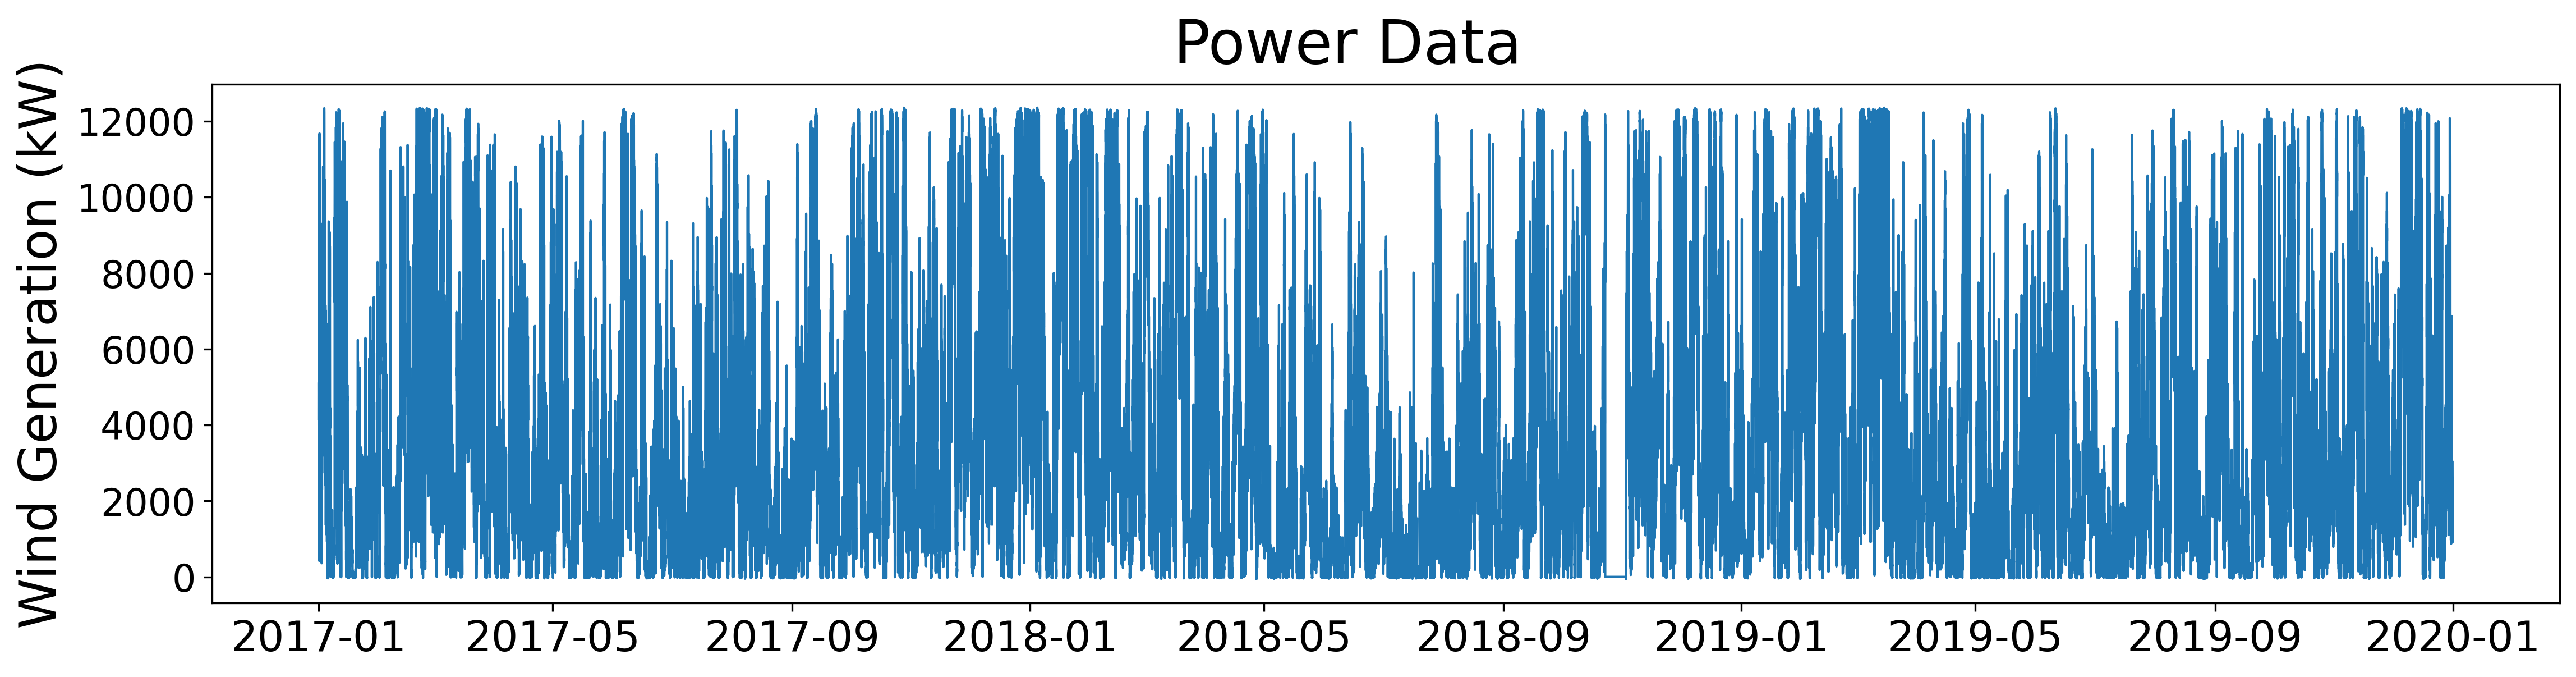

In [7]:
plt.rcParams['figure.dpi'] = 300

aggregated_data = sorted_df.groupby("# Date and time")["Power (kW)"].sum().reset_index()
aggregated_data.set_index('# Date and time', inplace=True)
print("aggregated_data = ",aggregated_data)

fig = plt.figure(figsize = [18,4])
fig.suptitle('Power Data', fontsize=26)

for a in range(1):
    ax = fig.add_subplot(1, 1, a+1) 
    ax.plot(aggregated_data['Power (kW)'], linewidth = 1)
#     plt.subplots_adjust(hspace=0.5)
    ax.set_ylabel("Wind Generation (kW)", fontsize = 22)
#     ax.title.set_text('Dataset ' + str(a))
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

print("total values in aggregated_data = ",len(aggregated_data['Power (kW)']))


# Missing values imputation

In [9]:
# MISSING VALUES IMPUTATION 

data_missing = sorted_df
data_missing_copy = data_missing.copy()

columns_to_exclude = ['# Date and time']
data_to_impute = data_missing.drop(columns=columns_to_exclude)
print("data_to_impute = =",data_to_impute)

whatev1 = np.float32(data_to_impute['Power (kW)'])
nested_array = np.array([[item] for item in whatev1])
# print("nested_array = ",nested_array)
# print("len(nested_array) = ", len(nested_array))

# X_12 = [[1],[2],[np.nan],[4]]
X_12 = nested_array[:500000]

# X_12 = nested_array
# print("X_12 = ",X_12)
# print("len(X_12) = ",len(X_12))
print("start: ",datetime.now())

imputer = KNNImputer(n_neighbors=2, weights="uniform")
output = imputer.fit_transform(X_12)

# print("output  =",output)
print("len(output) = ",len(output))
print("end: ",datetime.now())

data_to_impute = =         Power (kW)
0       840.748535
1       795.151123
2       716.353943
3       339.618103
4       916.475342
...            ...
946075  265.015195
946076  193.669499
946077  433.670004
946078  293.376791
946079  268.443102

[946080 rows x 1 columns]
start:  2024-03-26 16:38:00.825788
len(output) =  500000
end:  2024-03-26 16:39:57.059456


In [10]:
X_13 = nested_array[500000:]

# print("X_13 = ",X_13)
print("len(X_13) = ",len(X_13))
print("start: ",datetime.now())

imputer = KNNImputer(n_neighbors=2, weights="uniform")
output_2 = imputer.fit_transform(X_13)

# print("output  =",output_2)
print("len(output) = ",len(output_2))
print("end: ",datetime.now())

len(X_13) =  446080
start:  2024-03-26 16:47:04.963032
len(output) =  446080
end:  2024-03-26 16:51:51.165847


In [12]:
output_flat1 = output.flatten('F')
output_flat1 = pd.DataFrame(output_flat1)
# print(output_flat1)

output_flat2 = output_2.flatten('F')
output_flat2 = pd.DataFrame(output_flat2)
# print(output_flat2)

output_total = pd.concat([output_flat1, output_flat2], ignore_index = True)
print("output_total = ",output_total)

null_count_output = output_total[0].isna().sum().sum()  
print('Number of null values = ', null_count_output)

# null_sorted_values_output = output_total.isna()
# print("null_sorted_values = ", null_sorted_values_output)

output_total =                   0
0       840.748535
1       795.151123
2       716.353943
3       339.618103
4       916.475342
...            ...
946075  265.015198
946076  193.669495
946077  433.670013
946078  293.376801
946079  268.443115

[946080 rows x 1 columns]
Number of null values =  0


In [13]:
data_filled = data_missing_copy
# print(data_filled)

null_count_data_filled = data_filled.isnull().sum().sum()  
print('null_count_data_filled = ', null_count_data_filled)

data_filled['Power (kW)'] = output_total[0]
# data_filled.iloc[0:500]

print("data_filled = ", data_filled)

null_count_output_filled = data_filled['Power (kW)'].isna().sum().sum()  
print('Current number of null values = ', null_count_output_filled)

null_count_data_filled =  15005
data_filled =             # Date and time  Power (kW)
0      2017-01-01 00:00:00  840.748535
1      2017-01-01 00:00:00  795.151123
2      2017-01-01 00:00:00  716.353943
3      2017-01-01 00:00:00  339.618103
4      2017-01-01 00:00:00  916.475342
...                    ...         ...
946075 2019-12-31 23:50:00  265.015198
946076 2019-12-31 23:50:00  193.669495
946077 2019-12-31 23:50:00  433.670013
946078 2019-12-31 23:50:00  293.376801
946079 2019-12-31 23:50:00  268.443115

[946080 rows x 2 columns]
Current number of null values =  0


In [14]:
aggregated_data = data_filled.groupby("# Date and time")["Power (kW)"].sum().reset_index()
aggregated_data.set_index('# Date and time', inplace=True)
print("aggregated_data = ",aggregated_data)

null_aggregated_data = aggregated_data[aggregated_data['Power (kW)'].isnull()]
print("null_aggregated_data = ",null_aggregated_data)

print("number of values = ", len(aggregated_data),",365 x 3 days total (3 years), divide and get 144 values per day (10 min res)")



aggregated_data =                        Power (kW)
# Date and time                 
2017-01-01 00:00:00  4153.685547
2017-01-01 00:10:00  4508.641602
2017-01-01 00:20:00  4429.392578
2017-01-01 00:30:00  5120.020996
2017-01-01 00:40:00  4756.708984
...                          ...
2019-12-31 23:10:00  1226.340332
2019-12-31 23:20:00  1244.064819
2019-12-31 23:30:00  1812.301636
2019-12-31 23:40:00  1924.825439
2019-12-31 23:50:00  1736.869995

[157680 rows x 1 columns]
null_aggregated_data =  Empty DataFrame
Columns: [Power (kW)]
Index: []
number of values =  157680 ,365 x 3 days total (3 years), divide and get 144 values per day (10 min res)


In [15]:
# save the file
aggregated_data.to_csv('Kelmarsh_data_imputed.csv', index=True)
